In [156]:
import pandas as pd
import numpy as np
import networkx as nx
import pickle as pkl

import scipy as sp
from scipy.sparse.csgraph import minimum_spanning_tree

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform
import community as community_louvain
from wordcloud import WordCloud

## Create Directed Trade Networks of Aggregated Import Value

In [157]:
temp = pd.read_stata("data/country_partner_sitcproductsection_year.dta")

In [158]:
#SITC revision 2 product code definitions
data_dict = pd.read_json('https://comtrade.un.org/data/cache/classificationS2.json')

In [159]:
data_cross = []
i = 0
for item_def in list(data_dict["results"]):
    if(i >= 2):
        data_cross.append([item_def["text"].split(" - ", 1)[0],item_def["text"].split(" - ", 1)[1], item_def["parent"]])
    i = i+1

product_codes = pd.DataFrame(data_cross, columns = ['code', 'product','parent'])

In [160]:
country_codes = pd.read_excel("data/ISO3166.xlsx")

#rename some columns for join with trade data
country_codes["location_code"] = country_codes["Alpha-3 code"]
country_codes["partner_code"] = country_codes["Alpha-3 code"]
country_codes["country_i"] = country_codes["English short name"]
country_codes["country_j"] = country_codes["English short name"]
product_codes["sitc_product_code"] = product_codes["code"]

In [161]:
def clean_df(df):
    #join trade data and descriptions
    df = pd.merge(df, country_codes[["location_code", "country_i"]],on = ["location_code"])
    df = pd.merge(df, country_codes[["partner_code", "country_j"]],on = ["partner_code"])
    df = pd.merge(df, product_codes[["sitc_product_code", "product"]], on = ["sitc_product_code"])

    imports1 = df[['location_id', 'partner_id', 'product_id', 'year',
       'import_value', 'sitc_eci', 'sitc_coi', 'location_code', 'partner_code',
       'sitc_product_code', 'country_i', 'country_j', 'product']]
    imports1 = imports1[imports1["import_value"] != 0]

    imports2 = df[['location_id', 'partner_id', 'product_id', 'year',
       'export_value', 'sitc_eci', 'sitc_coi', 'location_code', 'partner_code',
       'sitc_product_code', 'country_i', 'country_j', 'product']]
    imports2["temp1"] = imports2['partner_code']
    imports2["temp2"] = imports2['location_code']

    imports2['location_code'] = imports2["temp1"]
    imports2['partner_code'] = imports2["temp2"]
    imports2["import_value"] = imports2["export_value"]
    imports2 = imports2[imports2["import_value"] != 0]
    imports2 = imports1[['location_id', 'partner_id', 'product_id', 'year',
        'import_value', 'sitc_eci', 'sitc_coi', 'location_code', 'partner_code',
        'sitc_product_code', 'country_i', 'country_j', 'product']]
    
    imports = pd.concat([imports1, imports2], ignore_index=True)
    
    #uk_trade = imports[(imports['location_code'] == 'GBR') | (imports['partner_code'] == 'GBR')]

    trade_agg = imports.groupby(["partner_code","location_code"])["import_value"].sum().reset_index()

    return trade_agg

In [162]:
#import trade data
years_data = []
for i in range(2009,2022):
    file_name = (f"data/country_partner_sitcproduct4digit_year_{i}.dta")
    year_data = pd.read_stata(file_name)
    trade = clean_df(year_data)
    years_data.append(trade)

In [163]:
eu_country_codes = ['GBR','AUT', 'BEL', 'BGR', 'HRV', 'CYP', 'CZE', 'DNK', 'EST', 'FIN', 'CHN', 'USA', 'GRC', 'HUN', 'IRL', 'DEU', 'LVA', 'LTU', 'LUX', 'MLT', 'NLD', 'POL', 'PRT', 'ROU', 'SVK', 'SVN', 'ESP', 'SWE']

In [165]:
graphs = []

for y in years_data:
    trade_df = pd.DataFrame(
                {
                    "source": list(y['location_code']),
                    "target": list(y['partner_code']),
                    "weight": list(y['import_value'])
                }
            )
    G = nx.from_pandas_edgelist(trade_df, source='source', target='target', edge_attr=True, create_using=nx.DiGraph)

    for i in G.nodes:
        if i in eu_country_codes:
            G.nodes[i]["EU"] = True
        else:
            G.nodes[i]["EU"] = False

    graphs.append(G)

## Visualize Change in Network Properties

### In-Degree and Out-Degree

In [166]:
us_in_connec = []
ger_in_connec = []
chn_in_connec = []
uk_in_connec = []

us_out_connec = []
ger_out_connec = []
chn_out_connec = []
uk_out_connec = []

for i in graphs:
    us_in_connec.append(i.in_degree('USA'))
    ger_in_connec.append(i.in_degree('DEU'))
    chn_in_connec.append(i.in_degree('CHN'))
    uk_in_connec.append(i.in_degree('GBR'))

    us_out_connec.append(i.out_degree('USA'))
    ger_out_connec.append(i.out_degree('DEU'))
    chn_out_connec.append(i.out_degree('CHN'))
    uk_out_connec.append(i.out_degree('GBR'))

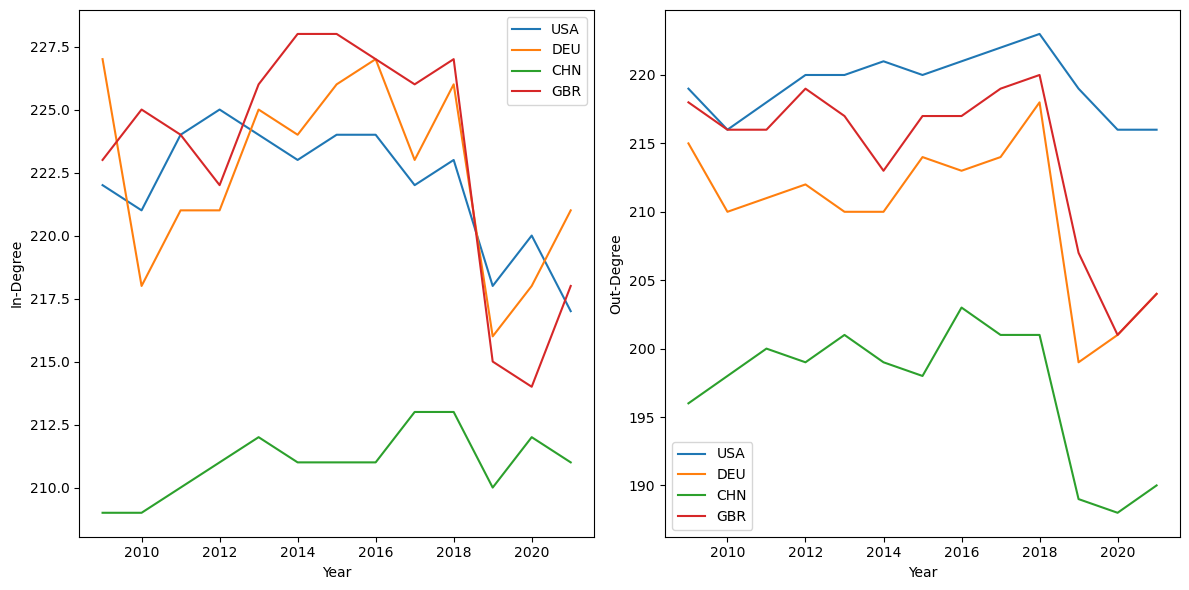

In [167]:
x = range(2009,2022)

# Create a figure and two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot fig1 on the first subplot
axs[0].plot(x, us_in_connec, label = "USA")
axs[0].plot(x, ger_in_connec, label = "DEU")
axs[0].plot(x, chn_in_connec, label = "CHN")
axs[0].plot(x, uk_in_connec, label = "GBR")

axs[0].set_xlabel("Year")
axs[0].set_ylabel("In-Degree")

# Plot fig1 on the first subplot
axs[1].plot(x, us_out_connec, label = "USA")
axs[1].plot(x, ger_out_connec, label = "DEU")
axs[1].plot(x, chn_out_connec, label = "CHN")
axs[1].plot(x, uk_out_connec, label = "GBR")

axs[1].set_xlabel("Year")
axs[1].set_ylabel("Out-Degree")

# Adjust layout to prevent overlap
plt.tight_layout()

axs[0].legend()
axs[1].legend()

plt.show()

In [168]:
us_in_connec = []
ger_in_connec = []
chn_in_connec = []
uk_in_connec = []

us_out_connec = []
ger_out_connec = []
chn_out_connec = []
uk_out_connec = []

for i in graphs:
    us_in_connec.append(i.in_degree('DEU', weight='weight'))
    ger_in_connec.append(i.in_degree('ITA', weight='weight'))
    chn_in_connec.append(i.in_degree('FRA', weight='weight'))
    uk_in_connec.append(i.in_degree('GBR', weight='weight'))

    us_out_connec.append(i.out_degree('DEU', weight='weight'))
    ger_out_connec.append(i.out_degree('ITA', weight='weight'))
    chn_out_connec.append(i.out_degree('FRA', weight='weight'))
    uk_out_connec.append(i.out_degree('GBR', weight='weight'))

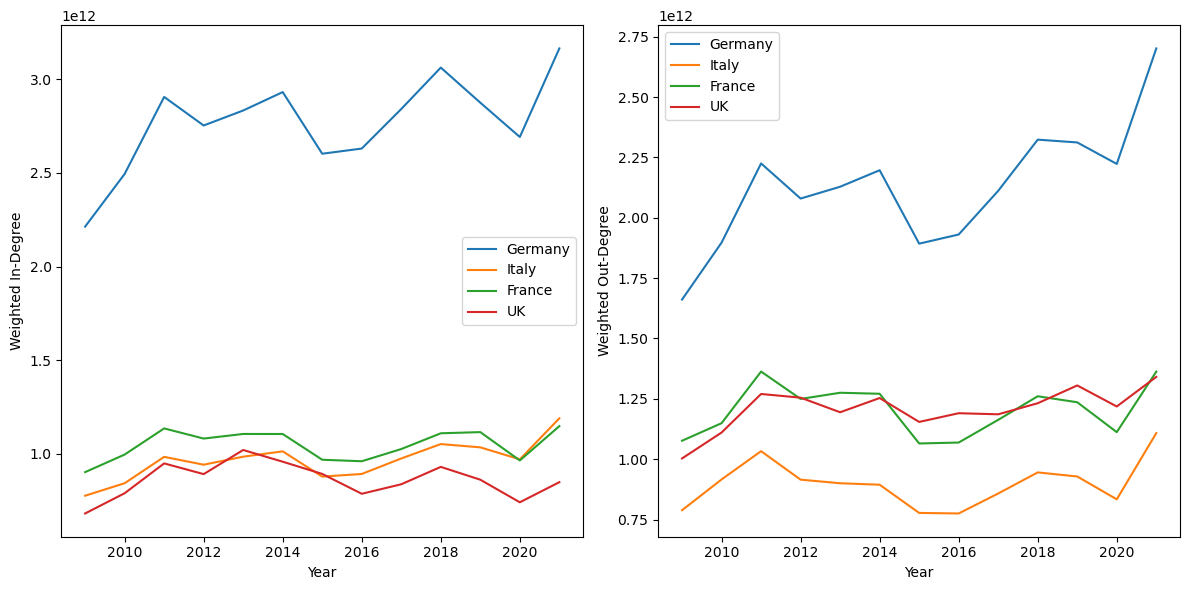

In [169]:
x = range(2009,2022)

# Create a figure and two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot fig1 on the first subplot
axs[0].plot(x, us_in_connec, label = "Germany")
axs[0].plot(x, ger_in_connec, label = "Italy")
axs[0].plot(x, chn_in_connec, label = "France")
axs[0].plot(x, uk_in_connec, label = "UK")

axs[0].set_xlabel("Year")
axs[0].set_ylabel("Weighted In-Degree")

# Plot fig1 on the first subplot
axs[1].plot(x, us_out_connec, label = "Germany")
axs[1].plot(x, ger_out_connec, label = "Italy")
axs[1].plot(x, chn_out_connec, label = "France")
axs[1].plot(x, uk_out_connec, label = "UK")

axs[1].set_xlabel("Year")
axs[1].set_ylabel("Weighted Out-Degree")

# Adjust layout to prevent overlap
plt.tight_layout()

axs[0].legend()
axs[1].legend()

plt.show()

### Centrality Measures

In [170]:
for i in graphs:
    g_distance_dict = {(e1, e2): 1 / weight for e1, e2, weight in i.edges(data='weight')}
    nx.set_edge_attributes(i, g_distance_dict, 'distance')

In [171]:
germany_out_central = []
ger_out_central = []
chn_out_central = []
uk_out_central = []

germany_in_central = []
ger_in_central = []
chn_in_central = []
uk_in_central = []

for i in graphs:
    germany_out_central.append(nx.closeness_centrality(i, u='DEU'))
    ger_out_central.append(nx.closeness_centrality(i, u='ITA'))
    chn_out_central.append(nx.closeness_centrality(i, u='FRA'))
    uk_out_central.append(nx.closeness_centrality(i, u='GBR'))

    germany_in_central.append(nx.closeness_centrality(i.reverse(), u='DEU'))
    ger_in_central.append(nx.closeness_centrality(i.reverse(), u='ITA'))
    chn_in_central.append(nx.closeness_centrality(i.reverse(), u='FRA'))
    uk_in_central.append(nx.closeness_centrality(i.reverse(), u='GBR'))

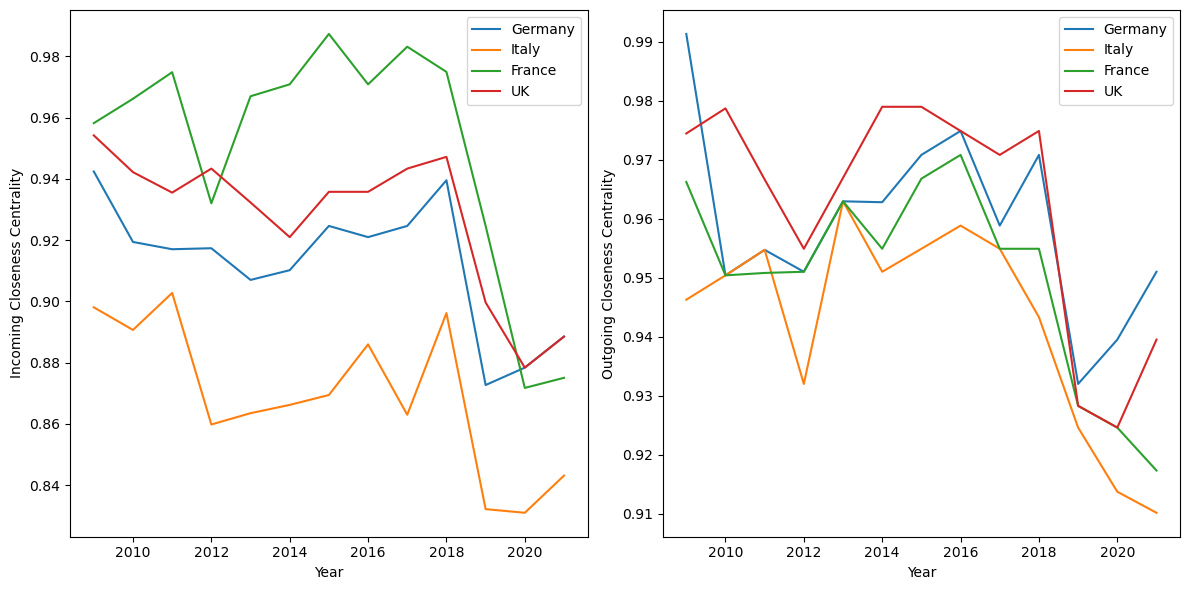

In [172]:
x = range(2009,2022)

# Create a figure and two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot fig1 on the first subplot
axs[0].plot(x, germany_in_central, label = "Germany")
axs[0].plot(x, ger_in_central, label = "Italy")
axs[0].plot(x, chn_in_central, label = "France")
axs[0].plot(x, uk_in_central, label = "UK")

axs[0].set_xlabel("Year")
axs[0].set_ylabel("Incoming Closeness Centrality")

# Plot fig1 on the first subplot
axs[1].plot(x, germany_out_central, label = "Germany")
axs[1].plot(x, ger_out_central, label = "Italy")
axs[1].plot(x, chn_out_central, label = "France")
axs[1].plot(x, uk_out_central, label = "UK")

axs[1].set_xlabel("Year")
axs[1].set_ylabel("Outgoing Closeness Centrality")

# Adjust layout to prevent overlap
plt.tight_layout()

axs[0].legend()
axs[1].legend()

plt.show()

## Sector Information

In [173]:
def clean_df(df):
    #join trade data and descriptions
    df = pd.merge(df, country_codes[["location_code", "country_i"]],on = ["location_code"])
    df = pd.merge(df, country_codes[["partner_code", "country_j"]],on = ["partner_code"])
    df = pd.merge(df, product_codes[["sitc_product_code", "product", "parent"]], on = ["sitc_product_code"])

    imports1 = df[['location_id', 'partner_id', 'product_id', 'year',
       'import_value', 'sitc_eci', 'sitc_coi', 'location_code', 'partner_code',
       'sitc_product_code', 'country_i', 'country_j', 'product', 'parent']]
    imports1 = imports1[imports1["import_value"] != 0]

    imports2 = df[['location_id', 'partner_id', 'product_id', 'year',
       'export_value', 'sitc_eci', 'sitc_coi', 'location_code', 'partner_code',
       'sitc_product_code', 'country_i', 'country_j', 'product', 'parent']]
    imports2["temp1"] = imports2['partner_code']
    imports2["temp2"] = imports2['location_code']

    imports2['location_code'] = imports2["temp1"]
    imports2['partner_code'] = imports2["temp2"]
    imports2["import_value"] = imports2["export_value"]
    imports2 = imports2[imports2["import_value"] != 0]
    imports2 = imports1[['location_id', 'partner_id', 'product_id', 'year',
        'import_value', 'sitc_eci', 'sitc_coi', 'location_code', 'partner_code',
        'sitc_product_code', 'country_i', 'country_j', 'product', 'parent']]
    
    trade = pd.concat([imports1, imports2], ignore_index=True)

    imports = trade[trade['location_code']=='GBR']
    exports = trade[trade['partner_code']=='GBR']

    return imports, exports

In [174]:
#import trade data
years_data_sectors = []
for i in range(2009,2022):
    file_name = (f"data/country_partner_sitcproduct4digit_year_{i}.dta")
    year_data = pd.read_stata(file_name)
    imports, exports = clean_df(year_data)
    years_data_sectors.append((imports, exports))

In [175]:
imports_2009_products = years_data_sectors[0][0].groupby(["parent"])["import_value"].sum().reset_index()
imports_2009_products['parent'] = imports_2009_products['parent'].str[:1]
parent_imports = imports_2009_products.groupby(["parent"])["import_value"].sum().reset_index()

In [176]:
import json

# Step 1: Open the file
with open('sitc_info.json', 'r') as file:
    # Step 2: Read the contents
    data = file.read()
    # Step 3: Parse JSON
    json_data = json.loads(data)

In [177]:
parent_imports["product_text"] = ""

In [178]:
for index, row in parent_imports.iterrows():
    # Step 3: Match values
    value_to_match = row['parent']
    
    # Check if the value exists in the JSON data
    if value_to_match in json_data:
        # Step 4: Perform actions based on matches
        # For example, replace the value with the corresponding value from the JSON data
        parent_imports.at[index, 'product_text'] = json_data[value_to_match]



In [179]:
parent_imports = parent_imports[parent_imports['product_text']!=""]

In [180]:
total_import_sum = parent_imports['import_value'].sum()

# Step 2: Calculate the import value of each product as a percentage of the total sum
parent_imports['import_value_percentage'] = (parent_imports['import_value'] / total_import_sum) * 100

In [181]:
parent_imports

parent  import_value                         product_text  \
0      0  7.772379e+10                Food And Live Animals   
1      1  1.540387e+10                Beverages And Tobacco   
2      2  1.955927e+10                      Crude Materials   
3      3  7.087852e+10                        Mineral Fuels   
4      4  3.073812e+09            Animal And Vegetable Oils   
5      5  1.203366e+11                            Chemicals   
6      6  1.137770e+11                   Manufactured Goods   
7      7  2.891811e+11    Machinery And Transport Equipment   
8      8  1.425790e+11  Miscellaneous Manufactured Articles   
9      9  1.504461e+11                   Goods Not Classif.   

   import_value_percentage  
0                 7.749448  
1                 1.535842  
2                 1.950156  
3                 7.066942  
4                 0.306474  
5                11.998156  
6                11.344128  
7                28.832799  
8                14.215835  
9                15.000220

## Community Detection

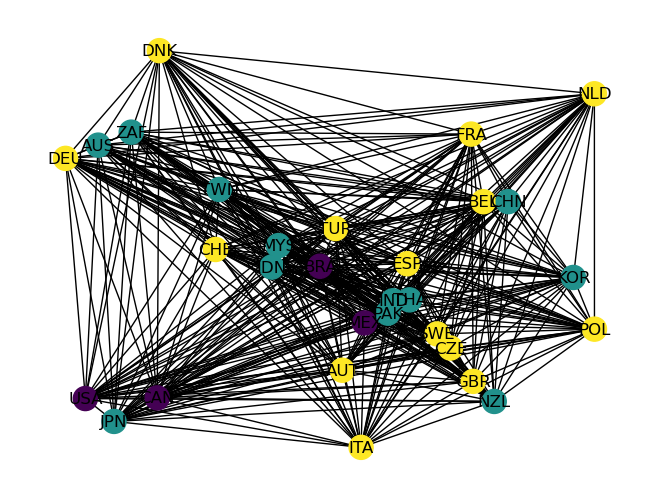

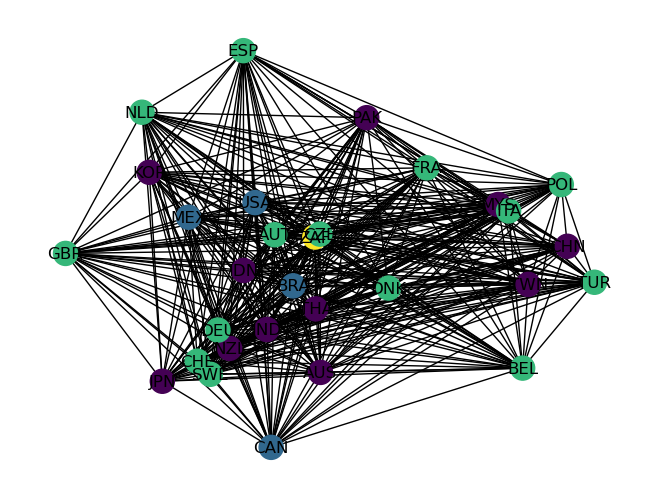

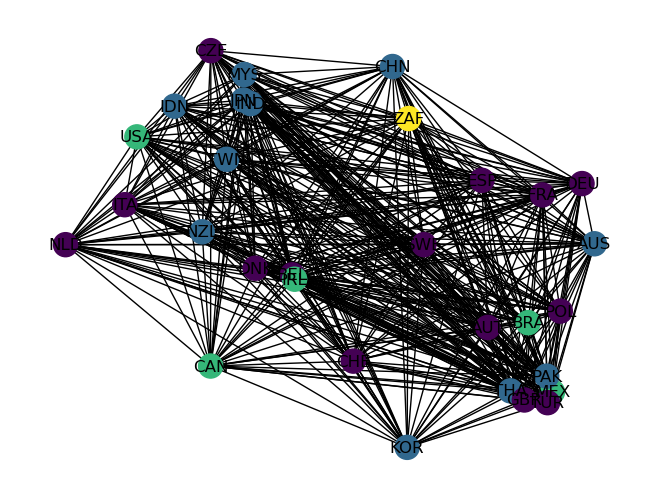

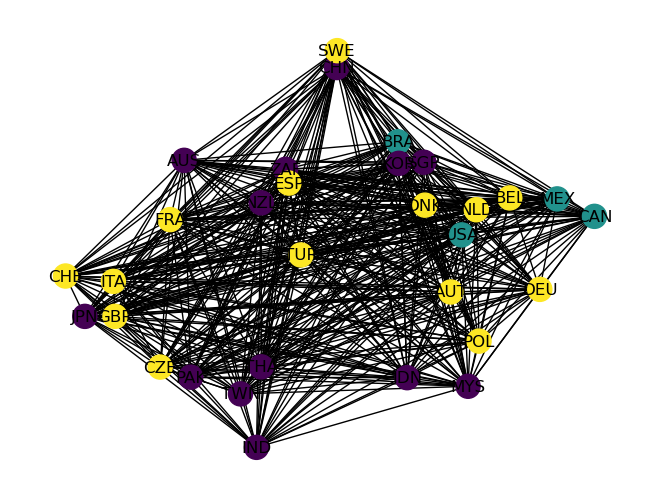

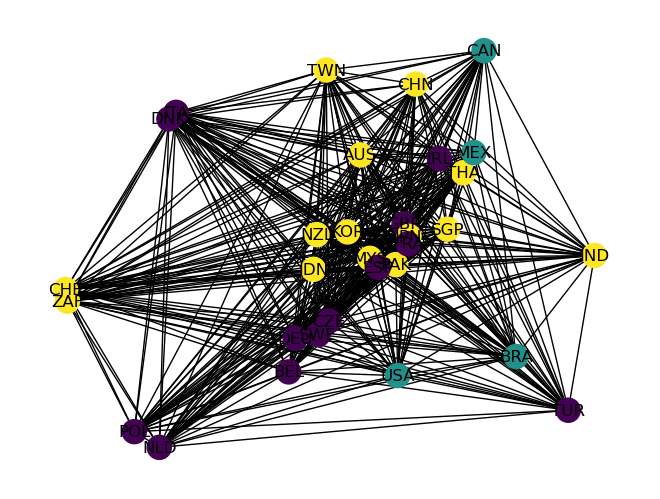

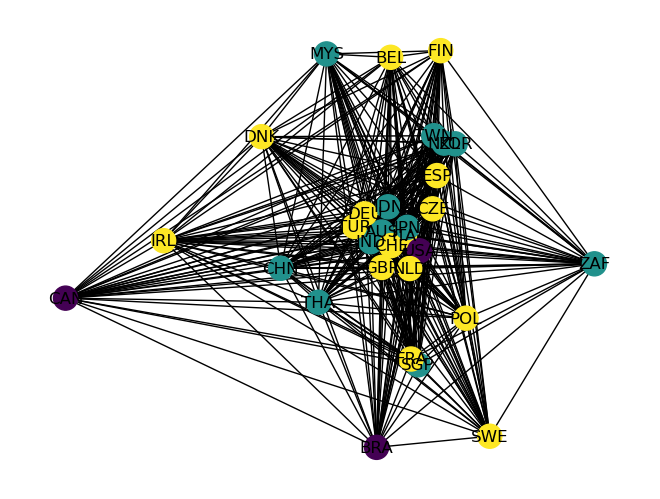

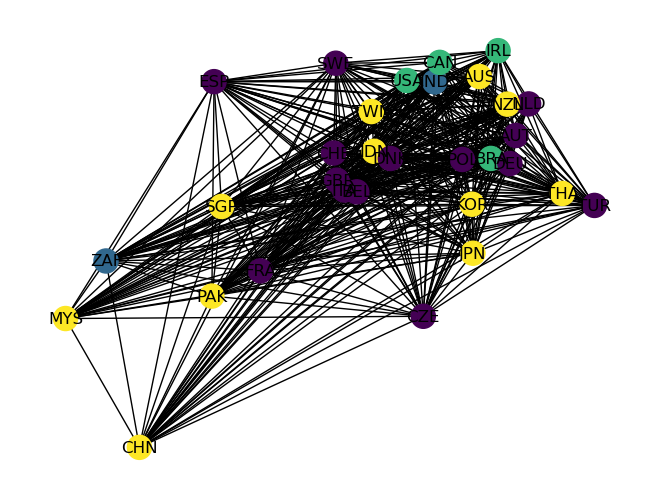

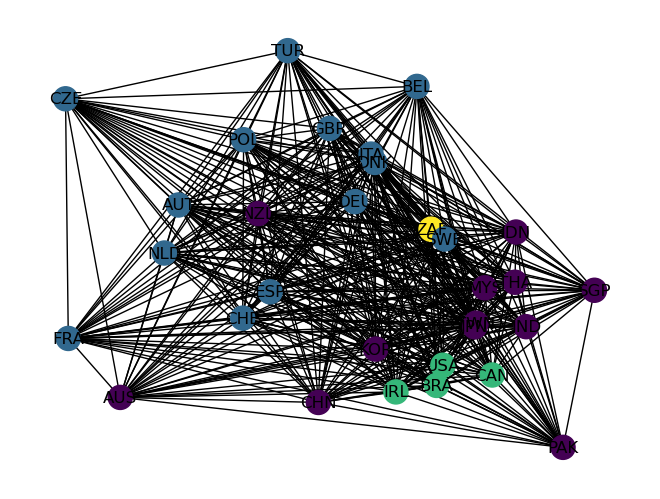

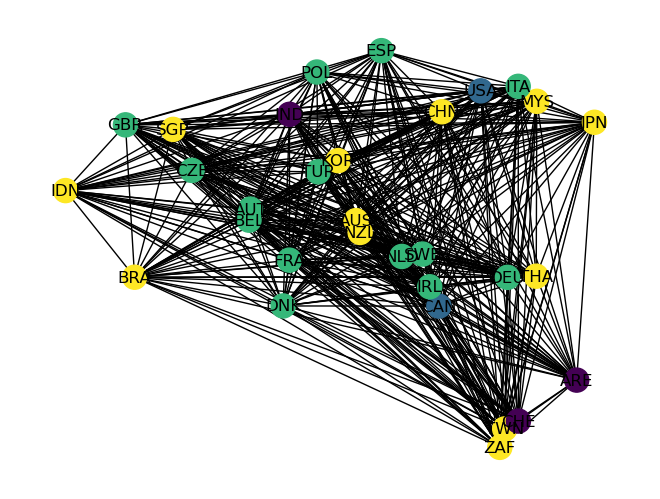

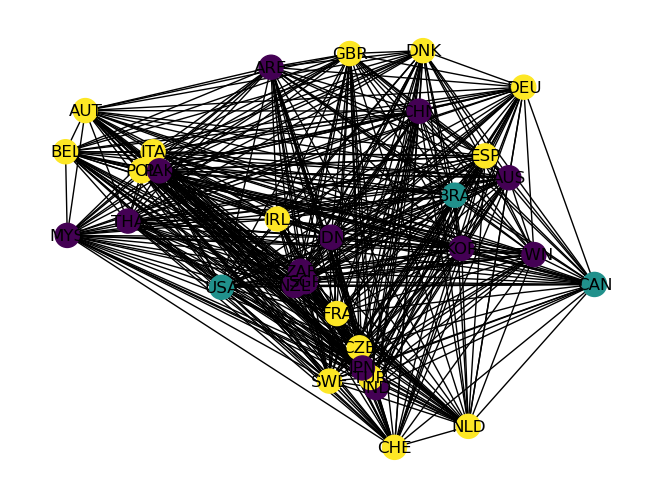

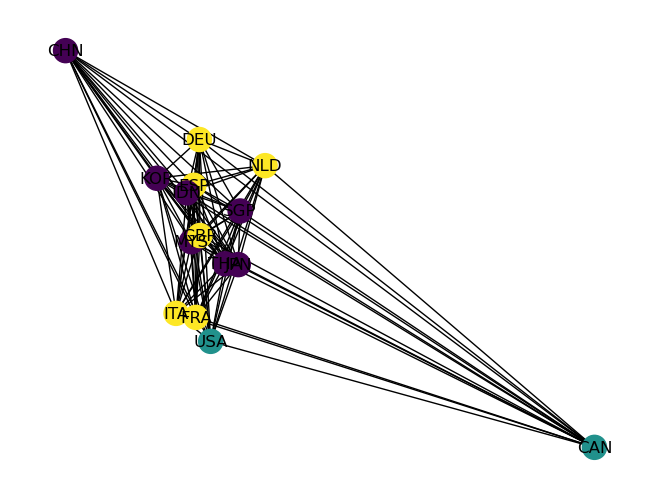

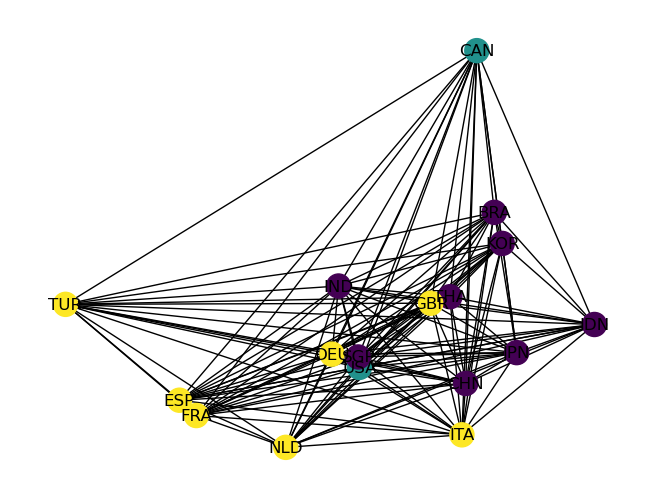

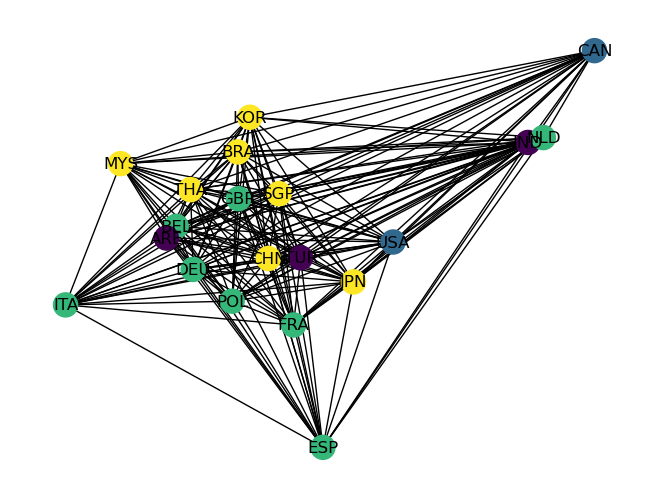

In [182]:
import community  # python-louvain library
for i in graphs:
    undirected_graph = i.to_undirected()
    partition = community.best_partition(undirected_graph)

    degree_centralities = nx.degree_centrality(undirected_graph)

    # Set a threshold for centrality to only visualize important nodes
    threshold = 0.9  # Adjust this threshold as needed

    # Filter nodes based on centrality
    important_nodes = [node for node, centrality in degree_centralities.items() if centrality >= threshold]

    # Create a subgraph containing only the important nodes and their edges
    important_subgraph = undirected_graph.subgraph(important_nodes)

    colors = [partition[node] for node in important_subgraph.nodes()]

    # Draw the subgraph
    pos = nx.spring_layout(important_subgraph)  # Position nodes using the spring layout algorithm
    nx.draw(important_subgraph, pos, node_color=colors, with_labels=True)
    plt.show()

## GDP Growth Rate Analysis

In [183]:
wb_indicators = pd.read_pickle("data/all_wb_indicators.pickle")

In [184]:
gdp = wb_indicators['NY.GDP.MKTP.KD.ZG']
gdp = gdp.rename(columns={"economy": "Country Code"})

In [185]:
country_codes = gdp.iloc[:,0]
gdp_rel_years = gdp.iloc[:,50:]

gdp_merge = pd.merge(country_codes, gdp_rel_years, left_index=True, right_index=True)

In [186]:
countries = ["USA","CHN","GBR","DEU"]

In [187]:
gdp_growth = gdp_merge[gdp_merge['Country Code'].isin(countries)]

In [188]:
gdp_growth

Country Code    YR2009     YR2010    YR2011    YR2012    YR2013    YR2014  \
40           CHN  9.398726  10.635871  9.550832  7.863736  7.766150  7.425764   
55           DEU -5.693836   4.179882  3.925193  0.418498  0.437591  2.209543   
81           GBR -4.510486   2.430073  1.067611  1.448457  1.819863  3.199703   
251          USA -2.599888   2.708857  1.549895  2.280688  1.841875  2.287776   

       YR2015    YR2016    YR2017    YR2018    YR2019     YR2020    YR2021  
40   7.041329  6.848762  6.947201  6.749774  5.950501   2.239702  8.109793  
55   1.491932  2.230000  2.680231  0.981233  1.056604  -3.696789  2.626987  
81   2.393103  2.165206  2.443570  1.705021  1.604309 -11.030858  7.524910  
251  2.706370  1.667472  2.241921  2.945385  2.294439  -2.767803  5.945485

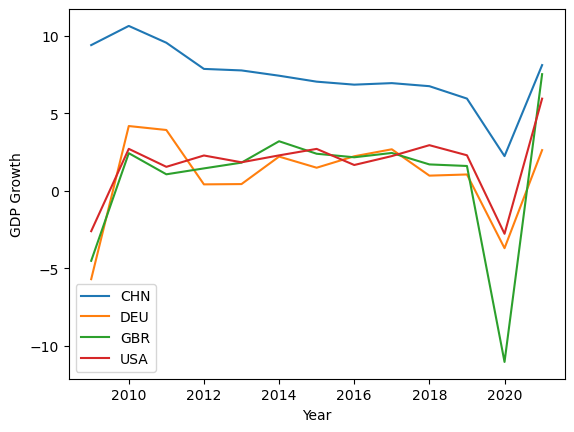

In [189]:
years = range(2009,2022)
for i in gdp_growth['Country Code'].unique():
    plt.plot(years, gdp_growth[gdp_growth['Country Code']==i].iloc[:,1:].values[0], label = i)

plt.xlabel("Year")
plt.ylabel("GDP Growth")
plt.legend()
plt.show()

In [190]:
gdp_per = wb_indicators['NY.GDP.PCAP.CD']
gdp_per = gdp_per.rename(columns={"economy": "Country Code"})

In [191]:
country_codes = gdp_per.iloc[:,0]
gdp_rel_years = gdp_per.iloc[:,50:]

gdp_merge = pd.merge(country_codes, gdp_rel_years, left_index=True, right_index=True)

In [192]:
countries = ["USA","CHN","GBR","DEU"]

In [193]:
gdp_per = gdp_merge[gdp_merge['Country Code'].isin(countries)]

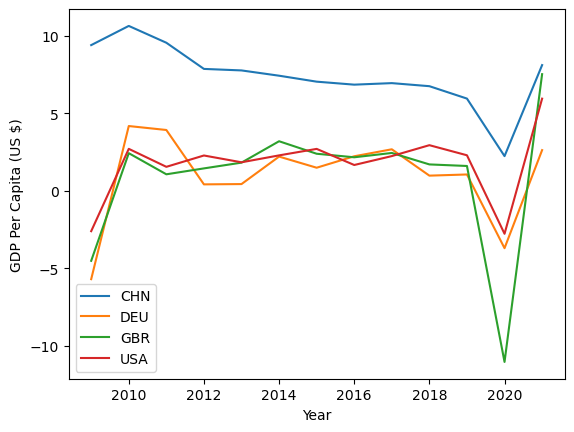

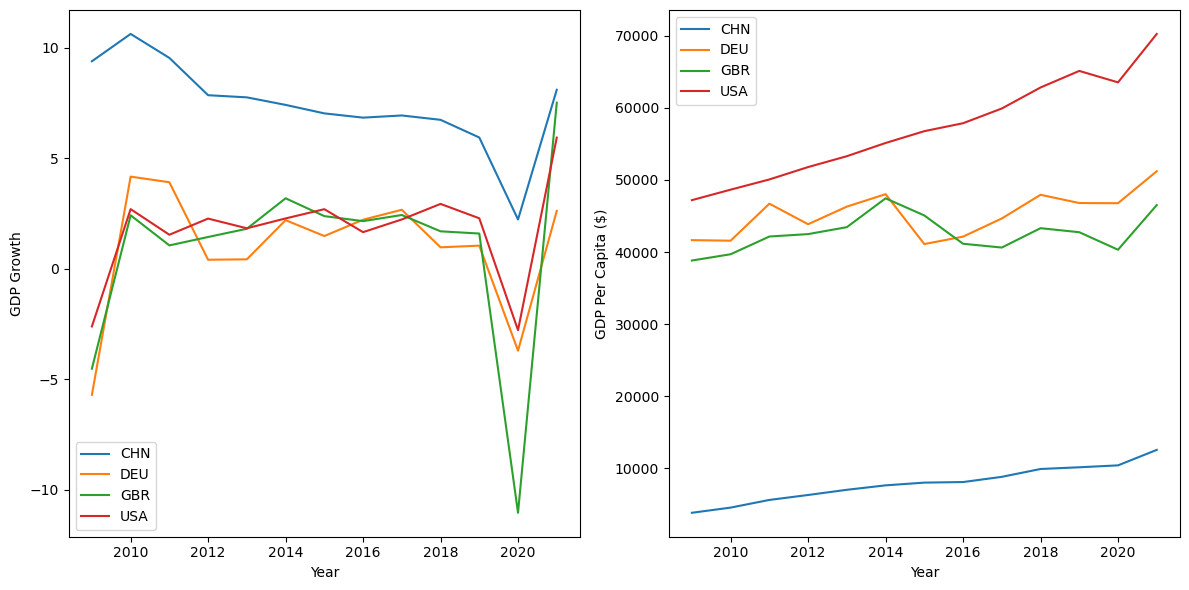

In [194]:
years = range(2009,2022)
for i in gdp_growth['Country Code'].unique():
    plt.plot(years, gdp_growth[gdp_growth['Country Code']==i].iloc[:,1:].values[0], label = i)

plt.xlabel("Year")
plt.ylabel("GDP Per Capita (US $)")
plt.legend()
plt.show()



fig, axs = plt.subplots(1, 2, figsize=(12, 6))

years = range(2009,2022)
for i in gdp_growth['Country Code'].unique():
    axs[0].plot(years, gdp_growth[gdp_growth['Country Code']==i].iloc[:,1:].values[0], label = i)

axs[0].set_xlabel("Year")
axs[0].set_ylabel("GDP Growth")

for i in gdp_growth['Country Code'].unique():
    axs[1].plot(years, gdp_per[gdp_per['Country Code']==i].iloc[:,1:].values[0], label = i)

axs[1].set_xlabel("Year")
axs[1].set_ylabel("GDP Per Capita ($)")

# Adjust layout to prevent overlap
plt.tight_layout()

axs[0].legend()
axs[1].legend()

plt.show()